# 1. Plot Species Richness per Habitat

In [6]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

In [21]:
from prettytable import PrettyTable

# Data
data = {
    'Amphibians': 2705,
    'Mammals': 3941,
    'Birds': 7262,
    'Total': 13908
}

# Create a PrettyTable
table = PrettyTable(['Taxa', 'Number'])

# Add rows to the table
for taxa, number in data.items():
    table.add_row([taxa, format(number, ',')])

# Print the table
print(table)


+------------+--------+
|    Taxa    | Number |
+------------+--------+
| Amphibians | 2,705  |
|  Mammals   | 3,941  |
|   Birds    | 7,262  |
|   Total    | 13,908 |
+------------+--------+


# 2. create barplots

In [42]:
import xarray as xr
import pandas as pd
import os
import pickle
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["forest"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65
model="GAM"

for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)


                    # Store mean changes in dictionaries
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = climate_change.where(oceania_mask_renamed == 1)
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = climate_land_change.where(oceania_mask_renamed == 1)



In [92]:
# Initialize averaged dictionaries
averaged_newvalue_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}
averaged_sum_bin_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}

# Iterate over each scenario and region
for scenario in scenarios:
    for region in regionlist:
        total_newvalue_change = []
        total_sum_bin_change = []

        # Iterate over each habitat, SDM, and GCM
        for habitat in habitats:
            for sdm in sdms:
                for gcm in gcms:
                    if region in mean_newvalue_change[habitat][scenario][sdm][gcm] and \
                       region in mean_sum_bin_change[habitat][scenario][sdm][gcm]:
                        # Collect all values for averaging
                        newvalue_change_region = mean_newvalue_change[habitat][scenario][sdm][gcm][region]
                        sum_bin_change_region = mean_sum_bin_change[habitat][scenario][sdm][gcm][region]

                        # Only consider non-null data
                        if newvalue_change_region is not None and sum_bin_change_region is not None:
                            total_newvalue_change.append(newvalue_change_region)
                            total_sum_bin_change.append(sum_bin_change_region)

        # Calculate the average change for the region under the current scenario
        # Ensure division is not by zero
        if total_newvalue_change and total_sum_bin_change:
            averaged_newvalue_change[scenario][region] = sum(total_newvalue_change) /len(total_newvalue_change)
            averaged_sum_bin_change[scenario][region] = sum(total_sum_bin_change) / len(total_sum_bin_change)


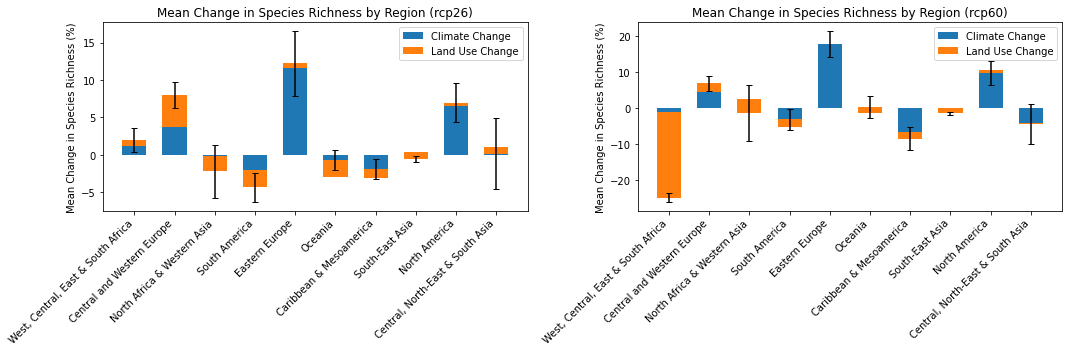

In [102]:
############### don't touch

import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]

# Scenarios and regions
scenarios = ["rcp26", "rcp60"]
regions = regionlist  # Make sure this is defined somewhere in your code
width = 0.3  # the width of the bars

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each scenario and plot
for i, scenario in enumerate(scenarios):
    newvalue_change_plot_data = []
    sum_bin_change_plot_data = []
    luc_change_plot_data = []
    total_change_plot_data = []
    std_dev_newvalue_list = []

    for region in regionlist:
        # Calculate standard deviation for climate change for each region


        # Remove outliers before calculating mean
        newvalue_change_clean = remove_outliers(averaged_newvalue_change[scenario][region].values)
        sum_bin_change_clean = remove_outliers(averaged_sum_bin_change[scenario][region].values)

        # Append mean of cleaned data
        newvalue_change_plot_data.append(np.nanmean(newvalue_change_clean))
        sum_bin_change_plot_data.append(np.nanmean(sum_bin_change_clean))

        # Calculate land use change for each region and append to list
        luc_change = np.nanmean(sum_bin_change_clean) - np.nanmean(newvalue_change_clean)
        luc_change_plot_data.append(luc_change)
        
        total_change = np.nanmean(newvalue_change_clean) + np.nanmean(luc_change)
        total_change_plot_data.append(total_change)
        
        std_dev_newvalue = np.std([np.nanmean(remove_outliers(mean_newvalue_change[habitat][scenario][sdm][gcm][region].values))
                                   for habitat in habitats for sdm in sdms for gcm in gcms])
        std_dev_newvalue_list.append(std_dev_newvalue)

    # Locations for the bars
    x = np.arange(len(regions)) /2

    # Plotting
    axes[i].bar(x, newvalue_change_plot_data, width, label='Climate Change')
    axes[i].bar(x, luc_change_plot_data, width, bottom=newvalue_change_plot_data, label='Land Use Change')
    axes[i].errorbar(x, total_change_plot_data, yerr=std_dev_newvalue_list, fmt='none', capsize=3, color='black')

    # Add some text for labels, title, and custom x-axis tick labels
    axes[i].set_ylabel('Mean Change in Species Richness (%)')
    axes[i].set_title(f'Mean Change in Species Richness by Region ({scenario})')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(regions, rotation=45, ha='right')
    axes[i].legend()

# Adjust layout
fig.tight_layout()
plt.show()


In [1]:
#now all together 

import xarray as xr
import pandas as pd
import os
import pickle
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["forest"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)
                        
                    weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                    weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                    cell_area_xr = weights_newvalue


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)


                    # Store mean changes in dictionaries
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = climate_change.where(oceania_mask_renamed == 1)
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = climate_land_change.where(oceania_mask_renamed == 1)


                    # Initialize averaged dictionaries
averaged_newvalue_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}
averaged_sum_bin_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}

# Iterate over each scenario and region
for scenario in scenarios:
    for region in regionlist:
        total_newvalue_change = []
        total_sum_bin_change = []

        # Iterate over each habitat, SDM, and GCM
        for habitat in habitats:
            for sdm in sdms:
                for gcm in gcms:
                    if region in mean_newvalue_change[habitat][scenario][sdm][gcm] and \
                       region in mean_sum_bin_change[habitat][scenario][sdm][gcm]:
                        # Collect all values for averaging
                        newvalue_change_region = mean_newvalue_change[habitat][scenario][sdm][gcm][region]
                        sum_bin_change_region = mean_sum_bin_change[habitat][scenario][sdm][gcm][region]

                        # Only consider non-null data
                        if newvalue_change_region is not None and sum_bin_change_region is not None:
                            total_newvalue_change.append(newvalue_change_region)
                            total_sum_bin_change.append(sum_bin_change_region)

        # Calculate the average change for the region under the current scenario
        # Ensure division is not by zero
        if total_newvalue_change and total_sum_bin_change:
            averaged_newvalue_change[scenario][region] = sum(total_newvalue_change) /len(total_newvalue_change)
            averaged_sum_bin_change[scenario][region] = sum(total_sum_bin_change) / len(total_sum_bin_change)

            ############### don't touch

import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]

# Scenarios and regions
scenarios = ["rcp26", "rcp60"]
regions = regionlist  # Make sure this is defined somewhere in your code
width = 0.3  # the width of the bars
results_df = pd.DataFrame(columns=['Scenario', 'Region', 'Climate Change', 'Land Use Change', 'Total Change'])

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each scenario and plot
for i, scenario in enumerate(scenarios):
    newvalue_change_plot_data = []
    sum_bin_change_plot_data = []
    luc_change_plot_data = []
    total_change_plot_data = []
    std_dev_newvalue_list = []

    for region in regionlist:
        # Calculate standard deviation for climate change for each region


        # Remove outliers before calculating mean
        newvalue_change_clean = remove_outliers(averaged_newvalue_change[scenario][region].values)
        sum_bin_change_clean = remove_outliers(averaged_sum_bin_change[scenario][region].values)
        
        sum_bin_change_clean = remove_outliers(averaged_sum_bin_change[scenario][region].values)
        # Append mean of cleaned data
        newvalue_change_plot_data.append(np.nanmean(newvalue_change_clean))
        sum_bin_change_plot_data.append(np.nanmean(sum_bin_change_clean))

        # Calculate land use change for each region and append to list
        
        
        luc_change = np.nanmean(sum_bin_change_clean) - np.nanmean(newvalue_change_clean)
        luc_change_plot_data.append(luc_change)
        
        total_change = np.nanmean(newvalue_change_clean) + np.nanmean(luc_change)
        total_change_plot_data.append(total_change)
        
        std_dev_newvalue = np.std([np.nanmean(remove_outliers(mean_newvalue_change[habitat][scenario][sdm][gcm][region].values))
                                   for habitat in habitats for sdm in sdms for gcm in gcms])
        std_dev_newvalue_list.append(std_dev_newvalue)
        
        results_df = results_df.append({
            'Scenario': scenario, 
            'Region': region, 
            'Climate Change': np.nanmean(newvalue_change_clean), 
            'Land Use Change': np.nanmean(luc_change), 
            'Total Change': np.nanmean(total_change),
            'Sum Change': np.mean(sum_bin_change_clean)
        }, ignore_index=True)


    # Locations for the bars
    x = np.arange(len(regions)) /2

    # Plotting
    axes[i].bar(x, newvalue_change_plot_data,width, bottom=luc_change_plot_data, label='Climate Change')
    axes[i].bar(x, luc_change_plot_data, width,  label='Land Use Change')
    axes[i].errorbar(x, total_change_plot_data, yerr=std_dev_newvalue_list, fmt='none', capsize=3, color='black')

    # Add some text for labels, title, and custom x-axis tick labels
    axes[i].set_ylim([-30, 30])
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].set_ylabel('Mean Change in Species Richness (%)')
    axes[i].set_title(f'Mean Change in Species Richness {habitat} ({scenario})')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(regions, rotation=45, ha='right')
    axes[i].legend()

# Adjust layout
fig.tight_layout()

plt.show()


NameError: name 'np' is not defined

In [23]:
newvalue_change_plot_data

[-2.0363787484450055,
 4.079422618818844,
 -2.6455380562333,
 -1.793549532058017,
 15.413404159757416,
 -1.2719167606177777,
 -5.667812731196449,
 -0.34423005961041675,
 7.419735268228939,
 -4.041752146279187]

In [10]:
print(results_df)

   Scenario                              Region  Climate Change  \
0     rcp26    Central, North-East & South Asia       -0.156707   
1     rcp26  West, Central, East & South Africa        0.000000   
2     rcp26          Central and Western Europe        0.051454   
3     rcp26         North Africa & Western Asia       -1.410158   
4     rcp26                       South America        0.000000   
5     rcp26                      Eastern Europe        2.856820   
6     rcp26                             Oceania        0.000000   
7     rcp26             Caribbean & Mesoamerica        0.000000   
8     rcp26                     South-East Asia        0.000000   
9     rcp26                       North America        1.165959   
10    rcp60    Central, North-East & South Asia       -1.057069   
11    rcp60  West, Central, East & South Africa        0.000000   
12    rcp60          Central and Western Europe        0.000000   
13    rcp60         North Africa & Western Asia       -1.87771

In [122]:
total_change_plot_data

[-24.874608928123852,
 6.843618010126372,
 -1.4461507580005821,
 -3.203692327856978,
 17.78925843780192,
 0.2455645278428673,
 -8.585163215191175,
 -1.474209656068406,
 9.645611569164815,
 -4.501446076790847]

In [113]:
averaged_newvalue_change['rcp60'][region].plot

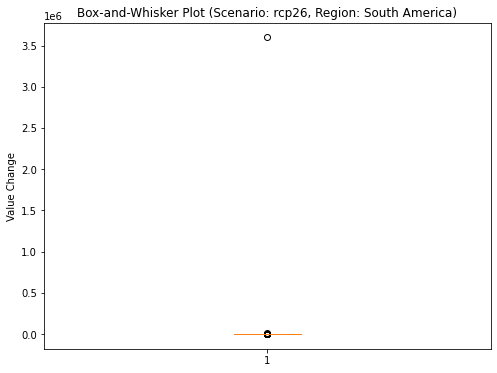

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your NumPy array
data = averaged_newvalue_change['rcp26']['South America'].values

# Filter out NaN values
clean_data = data[~np.isnan(data)]

# Check if clean_data is not empty
if clean_data.size > 0:
    plt.figure(figsize=(8, 6))

    # Creating the Tukey box-and-whisker plot
    plt.boxplot(clean_data, vert=True, patch_artist=True)

    plt.title('Box-and-Whisker Plot (Scenario: rcp26, Region: South America)')
    plt.ylabel('Value Change')

    plt.show()
else:
    print("No valid data available for plotting.")


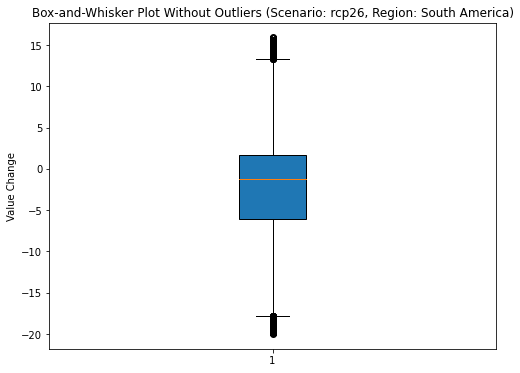

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your NumPy array
data = averaged_newvalue_change['rcp26']['South America'].values

# Filter out NaN values
clean_data = data[~np.isnan(data)]

# Check if clean_data is not empty
if clean_data.size > 0:
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(clean_data, 25)
    Q3 = np.percentile(clean_data, 75)
    IQR = Q3 - Q1

    # Define outliers as points outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
    non_outlier_data = clean_data[(clean_data >= Q1 - 1.5*IQR) & (clean_data <= Q3 + 1.5*IQR)]

    # Creating the box-and-whisker plot without outliers
    plt.figure(figsize=(8, 6))
    plt.boxplot(non_outlier_data, vert=True, patch_artist=True)

    plt.title('Box-and-Whisker Plot Without Outliers (Scenario: rcp26, Region: South America)')
    plt.ylabel('Value Change')

    plt.show()
else:
    print("No valid data available for plotting.")


In [34]:
clean_data

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
mean_sum_bin_change

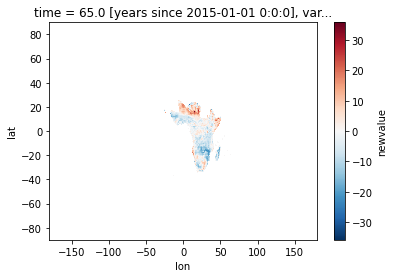

In [20]:
mean_newvalue_change[scenario][sdm][gcm][habitat].plot()

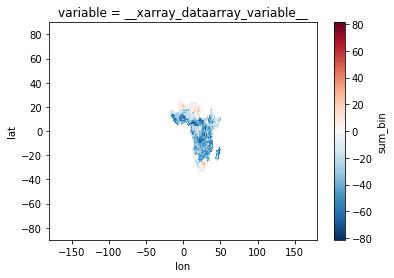

In [18]:
 mean_sum_bin_change[scenario][sdm][gcm][habitat].plot()

In [56]:
import xarray as xr
import pandas as pd

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']

# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}

scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
model="GAM"
for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_{future_time}_{scenario}_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    # Create an empty dictionary to store mean species richness for each habitat
    habitat_data_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}

    for habitat in habitats:
        # Open datasets for the current habitat
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc", decode_times=False).to_array().isel(variable=0)
        
        
                # Calculate differences
        diff_sumbin = sumbin_future - sumbin_hist

        # Apply the mask to the DataArrays
        region_data = {
            'sumbin_future': sumbin_future.where(oceania_mask_renamed == 1),
            'sumbin_hist': sumbin_hist.where(oceania_mask_renamed == 1),
            'diff_sumbin': diff_sumbin.where(oceania_mask_renamed == 1)
        }

        # Calculate mean species richness for each variable
        for variable, data_array in region_data.items():
            mean_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            habitat_data_dict[variable][habitat] = mean_species_richness

    # Store the sub-dictionary in the main dictionary for the current region
    mean_species_richness_dict['sumbin_future'][region] = habitat_data_dict['sumbin_future']
    mean_species_richness_dict['sumbin_hist'][region] = habitat_data_dict['sumbin_hist']
    mean_species_richness_dict['diff_sumbin'][region] = habitat_data_dict['diff_sumbin']

# Print the tables
for variable, region_data_dict in mean_species_richness_dict.items():
    print(f"\n{variable} Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)



sumbin_future Mean Species Richness:
                                          forest
West, Central, East & South Africa  1.640427e+06
Central and Western Europe          7.612014e+05
North Africa & Western Asia         2.857820e+05
South America                       2.220488e+06
Eastern Europe                      2.029638e+06
Oceania                             4.739175e+05
Caribbean & Mesoamerica             2.236312e+05
South-East Asia                     6.054505e+05
North America                       1.915013e+06
Central, North-East & South Asia    1.569486e+05

sumbin_hist Mean Species Richness:
                                          forest
West, Central, East & South Africa  1.599853e+06
Central and Western Europe          6.813585e+05
North Africa & Western Asia         2.943198e+05
South America                       2.344291e+06
Eastern Europe                      1.730031e+06
Oceania                             4.751110e+05
Caribbean & Mesoamerica             2.312400

In [29]:
region = 'West, Central, East & South Africa'

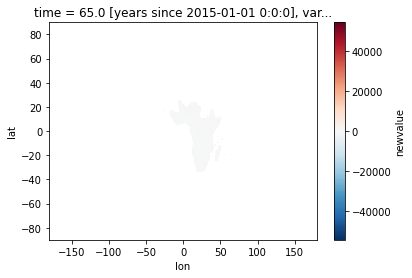

In [30]:
averaged_newvalue_change[scenario][region].plot()

In [ ]:
# test only 

import xarray as xr
import pandas as pd
import os
import pickle
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["forest"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)


                    # Store mean changes in dictionaries
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = climate_change.where(oceania_mask_renamed == 1)
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = climate_land_change.where(oceania_mask_renamed == 1)


                    # Initialize averaged dictionaries
averaged_newvalue_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}
averaged_sum_bin_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}

# Iterate over each scenario and region
for scenario in scenarios:
    for region in regionlist:
        total_newvalue_change = []
        total_sum_bin_change = []

        # Iterate over each habitat, SDM, and GCM
        for habitat in habitats:
            for sdm in sdms:
                for gcm in gcms:
                    if region in mean_newvalue_change[habitat][scenario][sdm][gcm] and \
                       region in mean_sum_bin_change[habitat][scenario][sdm][gcm]:
                        # Collect all values for averaging
                        newvalue_change_region = mean_newvalue_change[habitat][scenario][sdm][gcm][region]
                        sum_bin_change_region = mean_sum_bin_change[habitat][scenario][sdm][gcm][region]

                        # Only consider non-null data
                        if newvalue_change_region is not None and sum_bin_change_region is not None:
                            total_newvalue_change.append(newvalue_change_region)
                            total_sum_bin_change.append(sum_bin_change_region)

        # Calculate the average change for the region under the current scenario
        # Ensure division is not by zero
        if total_newvalue_change and total_sum_bin_change:
            averaged_newvalue_change[scenario][region] = sum(total_newvalue_change) /len(total_newvalue_change)
            averaged_sum_bin_change[scenario][region] = sum(total_sum_bin_change) / len(total_sum_bin_change)

            ############### don't touch

import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]

# Scenarios and regions
scenarios = ["rcp26", "rcp60"]
regions = regionlist  # Make sure this is defined somewhere in your code
width = 0.3  # the width of the bars
results_df = pd.DataFrame(columns=['Scenario', 'Region', 'Climate Change', 'Land Use Change', 'Total Change'])

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each scenario and plot
for i, scenario in enumerate(scenarios):
    newvalue_change_plot_data = []
    sum_bin_change_plot_data = []
    luc_change_plot_data = []
    total_change_plot_data = []
    std_dev_newvalue_list = []

    for region in regionlist:
        # Calculate standard deviation for climate change for each region


        # Remove outliers before calculating mean
        newvalue_change_clean = remove_outliers(averaged_newvalue_change[scenario][region].values)
        sum_bin_change_clean = remove_outliers(averaged_sum_bin_change[scenario][region].values)
        
        sum_bin_change_clean = remove_outliers(averaged_sum_bin_change[scenario][region].values)
        # Append mean of cleaned data
        newvalue_change_plot_data.append(np.nanmean(newvalue_change_clean))
        sum_bin_change_plot_data.append(np.nanmean(sum_bin_change_clean))

        # Calculate land use change for each region and append to list
        
        
        luc_change = np.nanmean(sum_bin_change_clean) - np.nanmean(newvalue_change_clean)
        luc_change_plot_data.append(luc_change)
        
        total_change = np.nanmean(newvalue_change_clean) + np.nanmean(luc_change)
        total_change_plot_data.append(total_change)
        
        std_dev_newvalue = np.std([np.nanmean(remove_outliers(mean_newvalue_change[habitat][scenario][sdm][gcm][region].values))
                                   for habitat in habitats for sdm in sdms for gcm in gcms])
        std_dev_newvalue_list.append(std_dev_newvalue)
        
        results_df = results_df.append({
            'Scenario': scenario, 
            'Region': region, 
            'Climate Change': np.nanmean(newvalue_change_clean), 
            'Land Use Change': np.nanmean(luc_change), 
            'Total Change': np.nanmean(total_change),
            'Sum Change': np.mean(sum_bin_change_clean)
        }, ignore_index=True)


    # Locations for the bars
    x = np.arange(len(regions)) /2

    # Plotting
    axes[i].bar(x, newvalue_change_plot_data, width, label='Climate Change')
    axes[i].bar(x, luc_change_plot_data, width, bottom=newvalue_change_plot_data, label='Land Use Change')
    axes[i].errorbar(x, total_change_plot_data, yerr=std_dev_newvalue_list, fmt='none', capsize=3, color='black')

    # Add some text for labels, title, and custom x-axis tick labels
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].set_ylabel('Mean Change in Species Richness (%)')
    axes[i].set_title(f'Mean Change in Species Richness {habitat} ({scenario})')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(regions, rotation=45, ha='right')
    axes[i].legend()

# Adjust layout
fig.tight_layout()

plt.show()


In [96]:
# test only 

import xarray as xr
import pandas as pd
import os
import pickle
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["forest"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = sum_bin_future_sum_taxa

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)


                    # Store mean changes in dictionaries
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = sum_bin_future_sum_taxa.where(oceania_mask_renamed == 1)
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = sum_bin_hist_sum_taxa.where(oceania_mask_renamed == 1)


In [104]:
import numpy as np
import pandas as pd

# Assuming mean_newvalue_change and mean_sum_bin_change are dictionaries with your data
scenarios = ["rcp26", "rcp60"]
habitats = ["forest"]  # Add other habitats if you have them
regions = ['West, Central, East & South Africa']  # and other regions
for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = sum_bin_future_sum_taxa

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)


                    # Store mean changes in dictionaries
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = sum_bin_future_sum_taxa.where(oceania_mask_renamed == 1)
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = sum_bin_hist_sum_taxa.where(oceania_mask_renamed == 1)

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Scenario', 'Habitat', 'Region', 'Relative Change in New Value', 'Relative Change in Sum Bin'])

for scenario in scenarios:
    for habitat in habitats:
        for region in regions:
            newvalue_hist_mean = []
            newvalue_future_mean = []
            sum_bin_hist_mean = []
            sum_bin_future_mean = []

            for sdm in sdms:
                for gcm in gcms:

                    newvalue_hist_mean.append(mean_newvalue_change[habitat][scenario][sdm][gcm][region].sum())
                    newvalue_future_mean.append(mean_sum_bin_change[habitat][scenario][sdm][gcm][region].sum())
                    

            # Calculate the mean across all SDMs and GCMs
            newvalue_hist_avg = np.nanmean(newvalue_hist_mean)
            newvalue_future_avg = np.nanmean(newvalue_future_mean)

            # Calculate relative changes
            rel_change_newvalue = ((newvalue_future_avg - newvalue_hist_avg) / newvalue_hist_avg) * 100 if newvalue_hist_avg != 0 else np.nan
           

            # Add to DataFrame
            results_df = results_df.append({
                'Scenario': scenario,
                'Habitat': habitat,
                'Region': region,
                'Relative Change in New Value': rel_change_newvalue
            }, ignore_index=True)

# Display the results
print(results_df)


  Scenario Habitat                              Region  \
0    rcp26  forest  West, Central, East & South Africa   
1    rcp60  forest  West, Central, East & South Africa   

   Relative Change in New Value  Relative Change in Sum Bin  
0                     -1.936087                         NaN  
1                     51.637179                         NaN  


In [80]:
print(results_df)

   Scenario                              Region  Total Change Sum
0     rcp26  West, Central, East & South Africa      14452.177746
1     rcp26          Central and Western Europe      33505.419087
2     rcp26         North Africa & Western Asia     -10443.197029
3     rcp26                       South America     -27068.992807
4     rcp26                      Eastern Europe     164036.285468
5     rcp26                             Oceania      -2697.243853
6     rcp26             Caribbean & Mesoamerica      -2000.438967
7     rcp26                     South-East Asia      -1015.506975
8     rcp26                       North America     110558.891985
9     rcp26    Central, North-East & South Asia        266.716121
10    rcp60  West, Central, East & South Africa    -189619.143859
11    rcp60          Central and Western Europe      28442.076450
12    rcp60         North Africa & Western Asia      -6898.139116
13    rcp60                       South America     -19158.080121
14    rcp6

In [126]:
#get back to maps 
#now all together 

import xarray as xr
import pandas as pd
import os
import pickle
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["forest"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa
                    

            all_cc=
                    

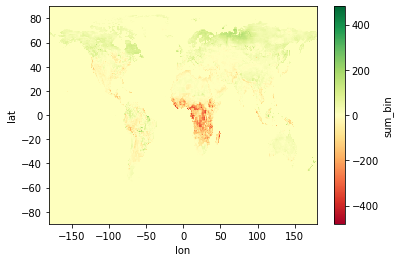

In [131]:
climate_land_change.plot(cmap='RdYlGn')

In [137]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Define your variables
scenarios = ["rcp26", "rcp60"]
habitats = ["forest"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

# Assuming mean_newvalue_change and mean_sum_bin_change contain the data for each combination of scenario, habitat, sdm, and gcm

# Calculate mean over SDMs and GCMs for climate_change and climate_land_change
mean_climate_change = {}
mean_climate_land_change = {}

for scenario in scenarios:
    for habitat in habitats:
        climate_change_total = None
        climate_land_change_total = None
        count = 0

        for sdm in sdms:
            for gcm in gcms:
                current_climate_change = mean_newvalue_change[habitat][scenario][sdm][gcm]
                current_climate_land_change = mean_sum_bin_change[habitat][scenario][sdm][gcm]

                if climate_change_total is None:
                    climate_change_total = current_climate_change.copy()
                    climate_land_change_total = current_climate_land_change.copy()
                else:
                    climate_change_total += current_climate_change
                    climate_land_change_total += current_climate_land_change
                
                count += 1

        mean_climate_change[scenario, habitat] = climate_change_total / count
        mean_climate_land_change[scenario, habitat] = climate_land_change_total / count

# Plotting
for (scenario, habitat), climate_change_da in mean_climate_change.items():
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    # Plot climate change
    climate_change_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
    plt.title(f'Climate Change for {scenario} - {habitat}')
    plt.show()

    # Plot climate land change
    climate_land_change_da = mean_climate_land_change[scenario, habitat]
    climate_land_change_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
    plt.title(f'Climate Land Change for {scenario} - {habitat}')
    plt.show()


TypeError: unsupported operand type(s) for +=: 'dict' and 'dict'

In [138]:
import xarray as xr
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"
regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
scenarios = ["rcp26", "rcp60"]
habitats = ["forest"]
historical_time = 1146
future_time = 65

# Initialize dictionaries to store mean climate change and land use change
mean_climate_change_dict = {scenario: {region: None for region in regionlist} for scenario in scenarios}
mean_land_use_change_dict = {scenario: {region: None for region in regionlist} for scenario in scenarios}

for region in regionlist:
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]

    for habitat in habitats:
        for scenario in scenarios:
            climate_change_total = None
            climate_land_change_total = None
            count = 0

            for sdm in sdms:
                for gcm in gcms:
                    with open(os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl"), "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)
                    with open(os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl"), "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)
                    with open(os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl"), "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)
                    with open(os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl"), "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)

                    climate_change = newvalue_future_sum_taxa - newvalue_hist_sum_taxa
                    climate_land_change = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                    if climate_change_total is None:
                        climate_change_total = climate_change
                        climate_land_change_total = climate_land_change
                    else:
                        climate_change_total += climate_change
                        climate_land_change_total += climate_land_change

                    count += 1

            mean_climate_change = climate_change_total / count
            mean_land_use_change = climate_land_change_total / count

            # Store the mean values in dictionaries
            mean_climate_change_dict[scenario][region] = mean_climate_change
            mean_land_use_change_dict[scenario][region] = mean_land_use_change

# Plotting code goes here
# Example: You can use plt.imshow() or any other plotting function suitable for your data


In [144]:
habitat

'forest'

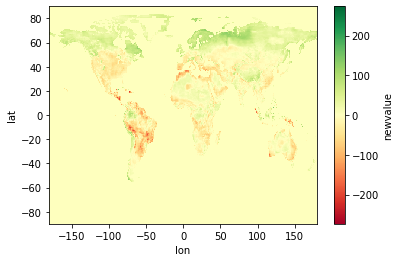

In [143]:
mean_climate_change_dict[scenario][region].plot(cmap='RdYlGn')

In [9]:
std_dev_newvalue_list

[1.9187646390946655,
 0.08583000959996963,
 0.06950354448697015,
 2.0669956011020734,
 0.0,
 0.9900193016467261,
 0.0,
 0.0,
 0.0,
 0.6933608019276948]

In [30]:
mean_newvalue_change[habitat][scenario][sdm][gcm][region]

<xarray.DataArray 'newvalue' (lat: 360, lon: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

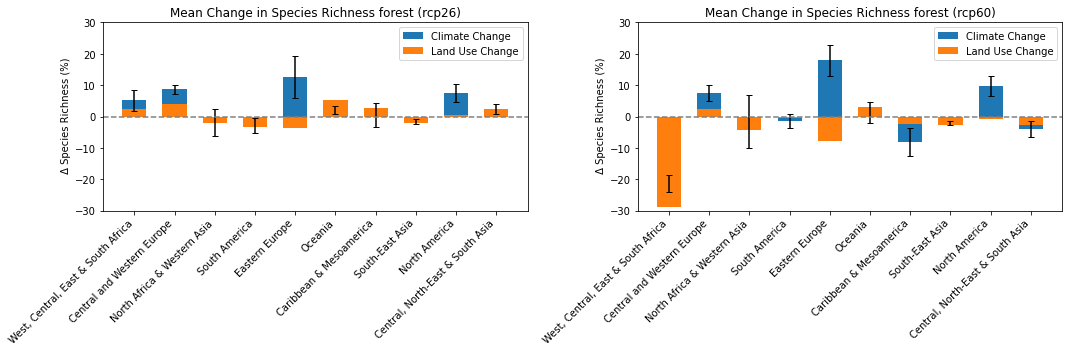

In [2]:
#now all together 

import xarray as xr
import pandas as pd
import os
import pickle
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["forest"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)


                    # Store mean changes in dictionaries
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = climate_change.where(oceania_mask_renamed == 1)
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = climate_land_change.where(oceania_mask_renamed == 1)


                    # Initialize averaged dictionaries
averaged_newvalue_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}
averaged_sum_bin_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}

# Iterate over each scenario and region
for scenario in scenarios:
    for region in regionlist:
        total_newvalue_change = []
        total_sum_bin_change = []

        # Iterate over each habitat, SDM, and GCM
        for habitat in habitats:
            for sdm in sdms:
                for gcm in gcms:
                    if region in mean_newvalue_change[habitat][scenario][sdm][gcm] and \
                       region in mean_sum_bin_change[habitat][scenario][sdm][gcm]:
                        # Collect all values for averaging
                        newvalue_change_region = mean_newvalue_change[habitat][scenario][sdm][gcm][region]
                        sum_bin_change_region = mean_sum_bin_change[habitat][scenario][sdm][gcm][region]

                        # Only consider non-null data
                        if newvalue_change_region is not None and sum_bin_change_region is not None:
                            total_newvalue_change.append(newvalue_change_region)
                            total_sum_bin_change.append(sum_bin_change_region)

        # Calculate the average change for the region under the current scenario
        # Ensure division is not by zero
        if total_newvalue_change and total_sum_bin_change:
            averaged_newvalue_change[scenario][region] = sum(total_newvalue_change) /len(total_newvalue_change)
            averaged_sum_bin_change[scenario][region] = sum(total_sum_bin_change) / len(total_sum_bin_change)

            ############### don't touch

import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(data):
    filtered_data = data[data <= 200000]
    return filtered_data

# Scenarios and regions
scenarios = ["rcp26", "rcp60"]
regions = regionlist  # Make sure this is defined somewhere in your code
width = 0.3  # the width of the bars
results_df = pd.DataFrame(columns=['Scenario', 'Region', 'Climate Change', 'Land Use Change', 'Total Change'])

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each scenario and plot
for i, scenario in enumerate(scenarios):
    newvalue_change_plot_data = []
    sum_bin_change_plot_data = []
    luc_change_plot_data = []
    total_change_plot_data = []
    std_dev_newvalue_list = []

    for region in regionlist:
        # Calculate standard deviation for climate change for each region


        # Remove outliers before calculating mean
        newvalue_change_clean = remove_outliers(averaged_newvalue_change[scenario][region].values)
        sum_bin_change_clean = remove_outliers(averaged_sum_bin_change[scenario][region].values)
        
        sum_bin_change_clean = remove_outliers(averaged_sum_bin_change[scenario][region].values)
        # Append mean of cleaned data
        newvalue_change_plot_data.append(np.nanmean(newvalue_change_clean))
        sum_bin_change_plot_data.append(np.nanmean(sum_bin_change_clean))

        # Calculate land use change for each region and append to list
        
        
        luc_change = np.nanmean(sum_bin_change_clean) - np.nanmean(newvalue_change_clean)
        luc_change_plot_data.append(luc_change)
        
        total_change = np.nanmean(newvalue_change_clean) + np.nanmean(luc_change)
        total_change_plot_data.append(total_change)
        
        std_dev_newvalue = np.std([np.nanmean(remove_outliers(mean_newvalue_change[habitat][scenario][sdm][gcm][region].values))
                                   for habitat in habitats for sdm in sdms for gcm in gcms])
        std_dev_newvalue_list.append(std_dev_newvalue)
        
        results_df = results_df.append({
            'Scenario': scenario, 
            'Region': region, 
            'Climate Change': np.nanmean(newvalue_change_clean), 
            'Land Use Change': np.nanmean(luc_change), 
            'Total Change': np.nanmean(total_change),
            'Sum Change': np.mean(sum_bin_change_clean)
        }, ignore_index=True)


    # Locations for the bars
    x = np.arange(len(regions)) /2

    # Plotting
    axes[i].bar(x, newvalue_change_plot_data, width, bottom=luc_change_plot_data, label='Climate Change')
    axes[i].bar(x, luc_change_plot_data, width,  label='Land Use Change')
    axes[i].errorbar(x, total_change_plot_data, yerr=std_dev_newvalue_list, fmt='none', capsize=3, color='black')

    # Add some text for labels, title, and custom x-axis tick labels
    axes[i].set_ylim([-30, 30])
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].set_ylabel(' \u0394 Species Richness (%)')
    axes[i].set_title(f'Mean Change in Species Richness {habitat} ({scenario})')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(regions, rotation=45, ha='right')
    axes[i].legend()

# Adjust layout
fig.tight_layout()

plt.show()


In [66]:
np.nanmedian(clean_data)

0.0

In [67]:
for scenario in scenarios:
    for region in regionlist:
        data_array = mean_newvalue_change['forest'][scenario]['GAM']['GFDL-ESM2M'][region]
        flattened_data = data_array.values.flatten()
        non_nan_data = flattened_data[~np.isnan(flattened_data)]
        number_of_zeros = (non_nan_data == 0).sum()
        percentage_of_zeros = (number_of_zeros / len(non_nan_data)) * 100

        print(f"Scenario: {scenario}, Region: {region}")
        print(f"Number of zero values: {number_of_zeros}")
        print(f"Percentage of zero values: {percentage_of_zeros:.2f}%\n")


Scenario: rcp26, Region: West, Central, East & South Africa
Number of zero values: 321
Percentage of zero values: 4.20%

Scenario: rcp26, Region: Central and Western Europe
Number of zero values: 923
Percentage of zero values: 21.69%

Scenario: rcp26, Region: North Africa & Western Asia
Number of zero values: 315
Percentage of zero values: 6.58%

Scenario: rcp26, Region: South America
Number of zero values: 485
Percentage of zero values: 7.27%

Scenario: rcp26, Region: Eastern Europe
Number of zero values: 1192
Percentage of zero values: 8.78%

Scenario: rcp26, Region: Oceania
Number of zero values: 1200
Percentage of zero values: 27.80%

Scenario: rcp26, Region: Caribbean & Mesoamerica
Number of zero values: 230
Percentage of zero values: 20.03%

Scenario: rcp26, Region: South-East Asia
Number of zero values: 953
Percentage of zero values: 38.58%

Scenario: rcp26, Region: North America
Number of zero values: 3542
Percentage of zero values: 21.89%

Scenario: rcp26, Region: Central, Nor

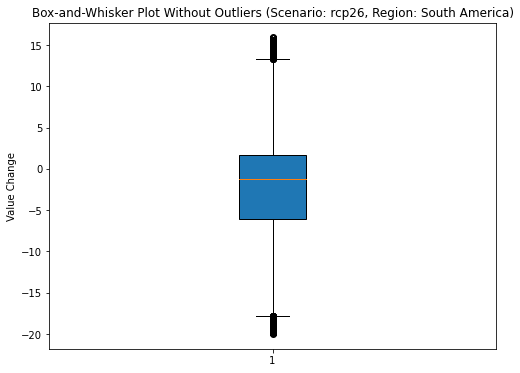

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your NumPy array
data = averaged_newvalue_change['rcp26']['South America'].values

# Filter out NaN values
clean_data = data[~np.isnan(data)]

# Check if clean_data is not empty
if clean_data.size > 0:
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(clean_data, 25)
    Q3 = np.percentile(clean_data, 75)
    IQR = Q3 - Q1

    # Define outliers as points outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
    non_outlier_data = clean_data[(clean_data >= Q1 - 1.5*IQR) & (clean_data <= Q3 + 1.5*IQR)]

    # Creating the box-and-whisker plot without outliers
    plt.figure(figsize=(8, 6))
    plt.boxplot(non_outlier_data, vert=True, patch_artist=True)

    plt.title('Box-and-Whisker Plot Without Outliers (Scenario: rcp26, Region: South America)')
    plt.ylabel('Value Change')

    plt.show()
else:
    print("No valid data available for plotting.")


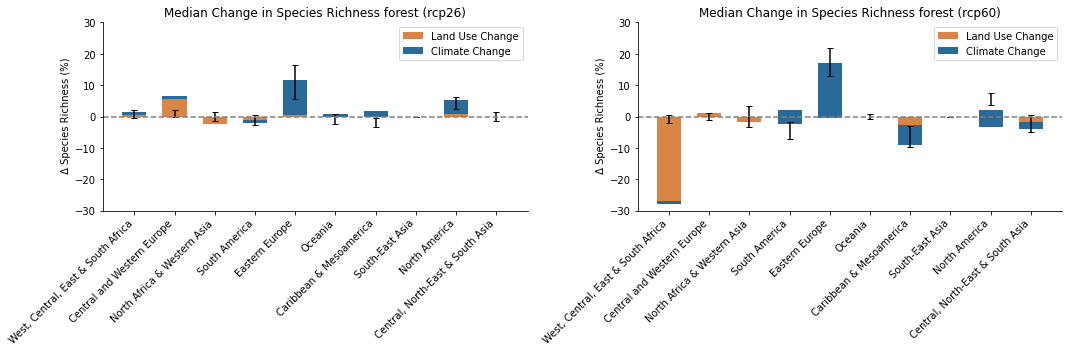

In [1]:
#median

import xarray as xr
import pandas as pd
import os
import pickle
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["forest"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

  # Create an empty dictionary to store mean species richness for each habitat
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for habitat in habitats:
    # Load pickled data
    mean_newvalue_change[habitat] = {}
    mean_sum_bin_change[habitat] = {}
    mean_land_use_change[habitat] = {}

    for scenario in scenarios:
        mean_newvalue_change[habitat][scenario] = {}
        mean_sum_bin_change[habitat][scenario] = {}
        mean_land_use_change[habitat][scenario] = {}

        for sdm in sdms:

            mean_newvalue_change[habitat][scenario][sdm] = {}
            mean_sum_bin_change[habitat][scenario][sdm] = {}
            mean_land_use_change[habitat][scenario][sdm] = {}


            for gcm in gcms:
                mean_newvalue_change[habitat][scenario][sdm][gcm] = {}
                mean_sum_bin_change[habitat][scenario][sdm][gcm] = {}
                mean_land_use_change[habitat][scenario][sdm][gcm] = {}


    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

    for habitat in habitats:
        for scenario in scenarios:
            for sdm in sdms:
                for gcm in gcms:
                    # Avoid re-initialization of the region level
                    
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = {}
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = {}


                    newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")
                    sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}'].pkl")

                    with open(newvalue_hist_sum_path, "rb") as f:
                        newvalue_hist_sum_taxa = pickle.load(f)

                    with open(newvalue_future_sum_path, "rb") as f:
                        newvalue_future_sum_taxa = pickle.load(f)

                    with open(sum_bin_hist_sum_path, "rb") as f:
                        sum_bin_hist_sum_taxa = pickle.load(f)

                    with open(sum_bin_future_sum_path, "rb") as f:
                        sum_bin_future_sum_taxa = pickle.load(f)


                                    # Avoid division by zero
                    non_zero_mask = newvalue_hist_sum_taxa != 0
                    climate_change = xr.where(non_zero_mask, (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) / newvalue_hist_sum_taxa * 100, 0)

                    non_zero_mask_sum_bin = sum_bin_hist_sum_taxa != 0
                    climate_land_change = xr.where(non_zero_mask_sum_bin, (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa) / sum_bin_hist_sum_taxa * 100, 0)


                    # Store mean changes in dictionaries
                    mean_newvalue_change[habitat][scenario][sdm][gcm][region] = climate_change.where(oceania_mask_renamed == 1)
                    mean_sum_bin_change[habitat][scenario][sdm][gcm][region] = climate_land_change.where(oceania_mask_renamed == 1)


                    # Initialize averaged dictionaries
averaged_newvalue_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}
averaged_sum_bin_change = {scenario: {region: None for region in regionlist} for scenario in scenarios}

# Iterate over each scenario and region
for scenario in scenarios:
    for region in regionlist:
        total_newvalue_change = []
        total_sum_bin_change = []

        # Iterate over each habitat, SDM, and GCM
        for habitat in habitats:
            for sdm in sdms:
                for gcm in gcms:
                    if region in mean_newvalue_change[habitat][scenario][sdm][gcm] and \
                       region in mean_sum_bin_change[habitat][scenario][sdm][gcm]:
                        # Collect all values for averaging
                        newvalue_change_region = mean_newvalue_change[habitat][scenario][sdm][gcm][region]
                        sum_bin_change_region = mean_sum_bin_change[habitat][scenario][sdm][gcm][region]

                        # Only consider non-null data
                        if newvalue_change_region is not None and sum_bin_change_region is not None:
                            total_newvalue_change.append(newvalue_change_region)
                            total_sum_bin_change.append(sum_bin_change_region)

        # Calculate the average change for the region under the current scenario
        # Ensure division is not by zero
        if total_newvalue_change and total_sum_bin_change:
            averaged_newvalue_change[scenario][region] = sum(total_newvalue_change) /len(total_newvalue_change)
            averaged_sum_bin_change[scenario][region] = sum(total_sum_bin_change) / len(total_sum_bin_change)

            ############### don't touch

import numpy as np
import matplotlib.pyplot as plt


# Scenarios and regions
scenarios = ["rcp26", "rcp60"]
regions = regionlist  # Make sure this is defined somewhere in your code
width = 0.3  # the width of the bars
results_df = pd.DataFrame(columns=['Scenario', 'Region', 'Climate Change', 'Land Use Change', 'Total Change'])

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


color_change = "#2a6a99"
color_land_use_change = "#d88546"

# Iterate over each scenario and plot
for i, scenario in enumerate(scenarios):
    newvalue_change_plot_data = []
    sum_bin_change_plot_data = []
    luc_change_plot_data = []
    total_change_plot_data = []
    std_dev_newvalue_list = []

    for region in regionlist:
        # Calculate standard deviation for climate change for each region


        # Remove outliers before calculating mean
        newvalue_change_clean = averaged_newvalue_change[scenario][region].values
        sum_bin_change_clean = averaged_sum_bin_change[scenario][region].values
        
    
        # Append mean of cleaned data
        newvalue_change_plot_data.append(np.nanmedian(newvalue_change_clean))
        sum_bin_change_plot_data.append(np.nanmedian(sum_bin_change_clean))

        # Calculate land use change for each region and append to list
        
        
        luc_change = np.nanmedian(sum_bin_change_clean) - np.nanmedian(newvalue_change_clean)
        luc_change_plot_data.append(luc_change)

        
        std_dev_newvalue = np.std([np.nanmedian(mean_newvalue_change[habitat][scenario][sdm][gcm][region].values)
                                   for habitat in habitats for sdm in sdms for gcm in gcms])
        std_dev_newvalue_list.append(std_dev_newvalue)
        
        results_df = results_df.append({
            'Scenario': scenario, 
            'Region': region, 
            'Climate Change': np.nanmean(newvalue_change_clean), 
            'Land Use Change': np.nanmean(luc_change), 
            #'Total Change': np.nanmean(total_change),
            'Sum Change': np.mean(sum_bin_change_clean)
        }, ignore_index=True)


    # Locations for the bars
    x = np.arange(len(regions)) /2

    # Plotting
    
    axes[i].bar(x, luc_change_plot_data, width,  label='Land Use Change', color= color_land_use_change)
    axes[i].bar(x, newvalue_change_plot_data,  width, bottom=luc_change_plot_data,label='Climate Change', color= color_change)
    axes[i].errorbar(x, newvalue_change_plot_data, yerr=std_dev_newvalue_list, fmt='none', capsize=3, color='black')
    axes[i].spines[[ 'top', 'right']].set_visible(False)
    # Add some text for labels, title, and custom x-axis tick labels
    axes[i].set_ylim([-30, 30])
    axes[i].axhline(y=0, color='gray', linestyle='--')
    axes[i].set_ylabel(' \u0394 Species Richness (%)')
    axes[i].set_title(f'Median Change in Species Richness {habitat} ({scenario})')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(regions, rotation=45, ha='right')
    axes[i].legend()

# Adjust layout
fig.tight_layout()

plt.show()
